# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [3]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [4]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
from collections import namedtuple, deque

for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.max(scores)))

Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0


### 4. Inplement the MADDPG algorithm

Multi-Agents Deep Deterministic Policy Gradient algorithm (MADDPG) is an extension of DDPG in a multi-agent environment. In the DDPG algorithm, two kinds of deep neural networks (Actor and Critic) are built for each agent. The Actor is a policy function that will be trained to map the agent's observations to its optimal action. Not like the value-based methods whose output are the probabilities in the action space, this policy-based method will directly output the expected actions. The Critic networks are Q-value functions that map the states and actions to the expected discounted return of an episode. While implementing the DDPG algorithm, a target network is built for each Actor and Critic, with the same architecture respectively. 
During training, 

- the agent gets an observation from the environment, then use the Actor to map from this observation to an action
- the action added with a noised is sent to the environment for the next observation, and the reward.
- the experience (observation, action, reward, next_observation) will be stored in a memory pool (replay buffer) 
- the next_observation become the observation of the next loop
- a batch of experiences is a sample from the replay buffer
- critic loss is calculated and the Critic optimizer performs a step of backpropagation
- J value (estimated expectation of the return with current observations and actions) is calculated, and the Actor optimizer performs a backpropagation step.
- soft update the target networks of Actor and Critic
- move to the next loop until the episode terminates.


In a Multi-Agent environment, the agents share their experiences during training, the critic network of each agent receives all the observations and actions in order to understand what happens to all the agents. the pseudo code from the [paper](https://arxiv.org/pdf/1706.02275.pdf) is shown below: 

![psedu_code](images/MADDPG_algorithm.PNG)

#### Architecture of the neural networks:

observation size (state_size): 24

numer of agents (num_agents): 2

**Actor (local / target):**

- layer 1: Linear(24, 256) with activation relu() 
- layer 2: Linear(256, 128) with activation relu()
- layer 3: Linear(128, 2) with activation tanh()

**Critic (local / target):**

- layer 1: Linear(24\*2, 256) with activation relu() 
- layer 2: Linear(256 + 2\*2, 128) with activation relu()
- layer 3: Linear(128, 1), no activation

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy

from collections import namedtuple, deque
import random

class Actor(nn.Module):
    def __init__(self, state_size, action_size, hiddens=(256,128)):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hiddens[0])
        self.fc2 = nn.Linear(hiddens[0], hiddens[1])
        self.fc3 = nn.Linear(hiddens[1], action_size)
        # initialize the weights of the last fc layer
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

class Critic(nn.Module):
    def __init__(self, state_size, action_size, hiddens=(256,128)):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hiddens[0])
        self.fc2 = nn.Linear(hiddens[0] + action_size, hiddens[1])
        self.fc3 = nn.Linear(hiddens[1], 1)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        hidden_0_out = F.relu(self.fc1(states))
        # actions are input in the second layer of the Critic network
        hidden_1_in = torch.cat((hidden_0_out, actions), dim=1)
        hidden_1_out = F.relu(self.fc2(hidden_1_in))
        return self.fc3(hidden_1_out)

class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.2, sigma=0.1):
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        s = self.state
        ds = self.theta * (self.mu - s) + self.sigma * np.random.standard_normal(self.size)
        self.state = s + ds
        return self.state

class ReplayBuffer:
    def __init__(self, buffer_size, seed):
        self.experience = namedtuple('Experience',field_names=('states', 'actions', 'rewards', 'next_states', 'dones'))
        self.memory = deque(maxlen=buffer_size)
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))

    def sample(self, device, batch_size):
        memory_sample = random.sample(self.memory, batch_size)
        states = torch.from_numpy(np.stack([experience.states for experience in memory_sample])).float().to(device)
        actions = torch.from_numpy(np.stack([experience.actions for experience in memory_sample])).float().to(device)
        rewards = torch.from_numpy(np.stack([experience.rewards for experience in memory_sample])).float().to(device)
        next_states = torch.from_numpy(np.stack([experience.next_states for experience in memory_sample])).float().to(device)
        dones = torch.from_numpy(np.stack([experience.dones for experience in memory_sample]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)
    
class DDPG_Agent:
    # initialize the DDPG_agent
    def __init__(self, device, num_agents, state_size, action_size, lr_actor, lr_critic):
        self.device = device
        # actor and critic (local/target) networks and optimizers
        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor_local.parameters(), lr=lr_actor)
        # input sizes of critic network are state_size * num_agents and action_size * num_agents 
        self.critic_local = Critic(state_size * num_agents, action_size * num_agents).to(device)
        self.critic_target = Critic(state_size * num_agents, action_size * num_agents).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic_local.parameters(), lr=lr_critic)

class MADDPG:
    # initialize the MADDPG
    def __init__(self, device, num_agents, state_size, action_size, lr_actor, lr_critic, buffer_size, seed, batch_size, gamma, tau):
        self.device = device
        self.num_agents = num_agents
        self.agents = [DDPG_Agent(device, num_agents, state_size, action_size, lr_actor, lr_critic) for i in range(self.num_agents)]
        self.replaybuffer = ReplayBuffer(buffer_size, seed)
        self.noise = OUNoise(action_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau    
        
    def reset_noise(self):
        self.noise.reset()
    
    def act(self, states, add_noise=True):
        states = torch.from_numpy(states).float().to(self.device)

        noise = np.zeros(self.noise.size)
        if add_noise:
            noise = self.noise.sample()
        
        actions = []  
        for i in range(self.num_agents):
            action = self.agents[i].actor_local(states[i]).cpu().data.numpy() + noise
            action = np.clip(action, -1.0, 1.0)
            actions.append(action)
        return np.array(actions)        
        
    def store(self, states, actions, rewards, next_states, dones):
        self.replaybuffer.add(states, actions, rewards, next_states, dones)

    def learn(self):
        for i , agent in enumerate(self.agents):
            states, actions, rewards, next_states, dones = self.replaybuffer.sample(self.device, self.batch_size)        
            # calculate critic_loss and make a step of optimizing the parameters of critic_local
            states_combined = states.view(self.batch_size, -1)
            actions_combined = actions.view(self.batch_size, -1)
            next_states_combined = next_states.view(self.batch_size, -1)
            next_actions = [self.agents[i].actor_target(next_states[:,i]) for i in range(self.num_agents)]
            next_actions_combined = torch.stack(next_actions, dim=1).view(self.batch_size, -1)
            q_next = agent.critic_target(next_states_combined, next_actions_combined)
            q_target = rewards[:,i].unsqueeze(1) + (1 - dones[:,i].unsqueeze(1)) * self.gamma * q_next
            q = agent.critic_local(states_combined, actions_combined)
            critic_loss = torch.nn.functional.mse_loss(q, q_target)
            agent.critic_optimizer.zero_grad()
            critic_loss.backward()
            agent.critic_optimizer.step()
            # calculate J and make a step of optimizing the parameters of actor_local
            agent.actor_optimizer.zero_grad()
            actions_pred = [self.agents[i].actor_local(states[:,i]) for i in range(self.num_agents)]
            actions_pred_combined = torch.stack(actions_pred, dim=1).view(self.batch_size, -1)
            J = -agent.critic_local(states_combined, actions_pred_combined).mean()
            J.backward()
            agent.actor_optimizer.step()

            # soft_update the actor_target and critic_target network
            self.soft_update(agent.actor_local.parameters(), agent.actor_target.parameters())
            self.soft_update(agent.critic_local.parameters(), agent.critic_target.parameters())        

    def soft_update(self, local_parameters, target_parameters):
        for local_param, target_param in zip(local_parameters, target_parameters):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + local_param.data * self.tau)


#### Perform the Training

Environment solved at episode: 4060! Average Score = 0.500600.


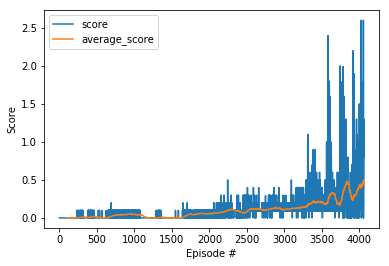

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

# Hyper-parameters
lr_actor = 1e-4
lr_critic = 5e-4
buffer_size = int(1e+5)
seed = 123
batch_size = 256
gamma = 0.99
tau = 1e-3

# An instance of MADDPG 
maddpg = MADDPG(device, num_agents, state_size, action_size, lr_actor, lr_critic, buffer_size, seed, batch_size, gamma, tau)

num_episode = 5000

scores_all = []
scores_window = deque(maxlen=100)
scores_average = []

from workspace_utils import active_session

with active_session():
    for episode_i in range(num_episode):
        maddpg.reset_noise()
        brain_info = env.reset(train_mode=True)[brain_name]
        states = brain_info.vector_observations
        score_episode = np.zeros(len(states))
        while True:
            actions = maddpg.act(states, add_noise=True)
            brain_info = env.step(actions)[brain_name]
            next_states = brain_info.vector_observations
            rewards = brain_info.rewards
            dones = brain_info.local_done
            score_episode += rewards
            maddpg.store(states, actions, rewards, next_states, dones)
            if len(maddpg.replaybuffer) > batch_size:
                maddpg.learn()
            if np.any(dones):
                break
            states = next_states

        scores_all.append(np.max(score_episode))
        scores_window.append(np.max(score_episode))

        if episode_i < 99:
            print("\rEpisode: {}\tScore: {:4f}".format(episode_i, scores_all[episode_i]), end="")
        else:
            scores_average.append(np.mean(scores_window))
            print("\rEpisode: {}\tScore: {:4f}\tAverage Score: {:4f}".format(episode_i, scores_all[episode_i], scores_average[episode_i - 99]), end="")
            if scores_average[episode_i - 99] > 0.5:
                print("\rEnvironment solved at episode: {}! Average Score = {:4f}.".format(episode_i, scores_average[episode_i - 99]))
                break

for i in range(num_agents):
    torch.save(maddpg.agents[i].actor_local.state_dict(), 'agent_{}_actor_checkpoint.pth'.format(i))
    torch.save(maddpg.agents[i].critic_local.state_dict(), 'agent_{}_critic_checkpoint.pth'.format(i))

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
plt.plot(np.arange(len(scores_all)), scores_all, label="score")
plt.plot(np.arange(len(scores_average))+99, scores_average, label="average_score")
plt.legend()
plt.xlabel("Episode #")
plt.ylabel("Score")
plt.show()

In [21]:
env.close()

### 5. Future ideas

Even the environment is solved, the training are not stable. With the same hyper parameters, sometimes it failed, sometimes it solved the problem. It is hard to tune the hyper parameters. The latest ones are inspired by [vivekthota16](https://github.com/vivekthota16/Project-Collaboration-and-Competition-Udacity-Deep-Reinforcement-Learning), especially the weight initialization of the last layers of the Actor and Critic. So the next work would be to try more hyperparameters to better understand the driving parameters for success.
Also, other technics like Prioritized Experience Replay is an option to try.